<a href="https://colab.research.google.com/github/lauriejd1/LD665PAPER11/blob/main/P5ld665PSet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set \#5  

## This problem set should be completed once you have finished Lecture 5 '_Regression and Prediction_'  

Pt. II, Paper 11: Data Analysis in Climate and Environmental Science  
_February 2025_

In **Lecture 5** we covered some of the following:

- Regression and least-squares fitting  
- Simple vs multiple linear regression  
- Higher-degree polynomial and nonlinear regression  
- Use of goodness-of-fit metrics and model validation procedures
- Interpolation of missing or irregularly spaced data  

---

In this problem set yo'll apply regression techniques to some real-world datasets.  After importing the necessary libraries and datasets, there will be **four main sections** to complete:

1. **Simple and multiple regression models**
   - Create spatial trend plots of temperature data
   - Retouch on skills learned in Lectures 3 and 5.

2. **Multi-linear regression**
   - Fit multiple linear regression models to Cambridge temperatures using climate-related predictors.  
   - Evaluate and interpret residuals using goodness-of-fit metrics.

3. **Nonlinear regression and curve fitting**  
   - Fit a given nonlinear model to climate time series data.  
   - Conduct cross-validation to evaluate out-of-sample model performance, and make future predictions.

*Each part be completed independently of the others.  If you get stuck, try to clearly articulate where/why you're stuck, then move on to a different section and come back to later!*

---

**Acknowledgments**: Please acknowledge external resources used in this PSet appropriately. This will not affect your marks.


## Import libraries
(as you work through the PSet, please identify and load in any relevant additional libraries)

In [ ]:
## For all your scientific computing needs
import numpy as np

## For reading tabular data
import pandas as pd

## For all things plotting
import matplotlib.pyplot as plt

## For easy statistical plotting of tabular data
import seaborn as sns

## For importing netcdf files
import xarray as xr

## inline plotting (i.e., show plots in notebook)
%matplotlib inline

## for plotting beautiful maps
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## And, let's mount our Google Drive, as we are loading external files
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 75.8 MB/s eta 0:00:00
Mounted at /content/drive


# Part 1: Trend map
The following questions touch on aspects covered in Demo's 1, 3, and 4 of Lecture 5.  You'll also need to draw upon Lecture 3's tutorials on loading in NetCDF data and using XArray to manipulate spatiotemporal data.


In Part 1 you'll work with surface temperature data from the NOAA 20th Century Reanalysis v3 (NOAA20Cv3; Slivinski et al., 2019) which spans from January 1836 to December 2015. The data can be found in the file "skt.mon.mean.nc", located in the L5 folder of our shared Google Drive.  Your goal is to calculate and map linear temperature trends for each grid point globally. So-called "trend maps" (e.g., [here](https://www.climate.gov/news-features/blogs/beyond-data/mapping-us-climate-trends)) are commonly used in climate science to compare how different regions experience varying rates of warming or cooling (or change, more broadly) over time.

The dataset has 360 longitude points (0˚ to 360˚), 181 latitude points (-90˚ to 90˚), and 2160 monthly observations. _There are no missing values to worry about_.  Your task will focus on the period from 1950 to 2015 CE and requires transforming the monthly data into annual means before performing the regression analysis.

**We'll break Part 1 into 3 tasks to complete (see below)**:

---

_Citation_:
Slivinski, L. C., Compo, G. P., Whitaker, J. S., et al. (2019), Towards a more reliable historical reanalysis: Improvements for version 3 of the Twentieth Century Reanalysis system. _QJR Meteorol Soc._ doi:10.1002/qj.3598.
Data: https://www.psl.noaa.gov/data/gridded/data.20thC_ReanV3.html

---


#### 1.1) _Extract and manipulate the NetCDF data_:
  - Use XArray to load the gridded historical temperature data from "skt.mon.mean.nc".
  - Using the 'time' variable within the NetCDF file, compute annual mean temperatures for each grid point (i.e., average across months within each year), and select the time period from 1950 to 2015.
  - Print the shape (`np.shape()`) of the resulting three-dimensional dataset to ensure you've extracted the correct dimensions.

---

A hint for extracting the correct dataset for this problem is provided at the end of this PSet.  Do try to figure it out yourself, first, however!


In [2]:
## Include code to answer 1.1, here:
filepath = "/content/drive/Shareddrives/GEOG-Paper_11_Envi_Data_Sci/L5/skt.mon.mean.nc"

# Open the dataset
ds = xr.open_dataset(filepath)

# Extract the temperature variable
temp = ds['skt']

# Calculate annual means and subset the data from 1950 to 2015
temp_annual = temp.groupby('time.year').mean().sel(year=slice(1950, 2015))

# Print the shape of the resulting dataset using np.shape()
print(np.shape(temp_annual))



(66, 181, 360)


#### 1.2) _Perform linear regression for each point on Earth_:
  - For each latitude-longitude pair, fit a linear regression model:
  $y_i = m_i \times t + b_i$
  where $y_i$​ is the mean annual temperature, $t$ is the array of years (i.e., 1950, 1951, ..., 2015), $m_i$​ is the slope or trend (temperature change per year), and $b_i$​ is the intercept  at grid point $i$.
  - At each latitude-longitude pairing, $i$, convert the slope value $m_i$ to temperature change **per century** and store it in a new array.
  - Print the range (min and max) of global temperature trend values you calculated.  


In [7]:
from scipy.stats import linregress

## Include code to answer 1.2, here:
# Open the dataset
ds = xr.open_dataset(filepath)


# Extract the temperature variable
temp = ds['skt']

# Calculate annual means and subset the data from 1950 to 2015
temp_annual = temp.groupby('time.year').mean().sel(year=slice(1950, 2015))

# Create an array to store the slope values (temperature change per century)
slope_century = np.full(temp_annual.shape[1:], np.nan)

# Get the years as an array (1950 to 2015)
years = np.arange(1950, 2016)

# Loop over each latitude-longitude point and fit a linear regression
for lat_idx in range(temp_annual.shape[1]):
    for lon_idx in range(temp_annual.shape[2]):
        # Extract the temperature values for this grid point
        temps = temp_annual[:, lat_idx, lon_idx].values

        # Perform linear regression to get the slope (temperature change per year)
        slope, intercept, _, _, _ = linregress(years, temps)

        # Convert the slope to temperature change per century (100 years)
        slope_century[lat_idx, lon_idx] = slope * 100  # Temperature change per century

# Print the range (min and max) of temperature trend values
print("Min temperature change per century:", np.min(slope_century))
print("Max temperature change per century:", np.max(slope_century))


Min temperature change per century: -4.156850885093219
Max temperature change per century: 15.485179038326994


#### 1.3) _Visualise the trend map and interpret the results ($<$250 words)_:
  - Plot the global map of temperature trends using `cartopy`. Use an appropriate colormap to represent the magnitude of the trend (e.g., shades of red for warming and blue for cooling). Include a labeled colorbar centred at 0˚C century$^{-1}$.
  - Identify the global region(s) with the strongest warming or cooling trends. Based on your past coursework (spanning back to Part 1A!) can you postulate on what's driving these regional changes ($\leq$250 words)?

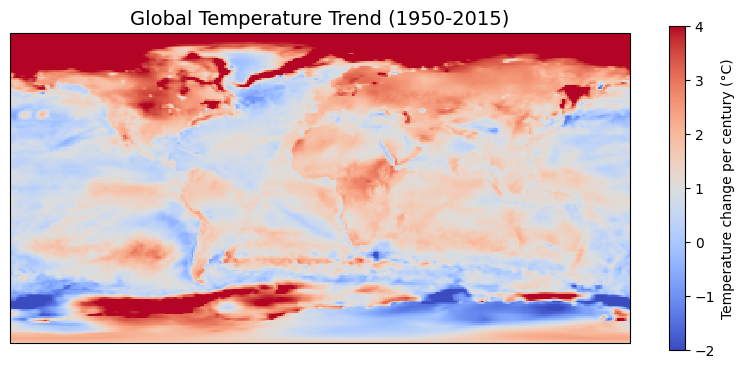

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import matplotlib.colorbar as cbar
from matplotlib.colors import ListedColormap
## Include code to answer 1.3, here:
# (Refer back to L3 for example code for plotting spatial maps)

# Set normalization limits
vmin = -2
vmax = 4
# Create a Cartopy plot with a global map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Set the extent of the map to cover the entire globe

# Add land and ocean features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot the temperature trend map
c = ax.pcolormesh(ds['lon'], ds['lat'], slope_century, cmap='coolwarm', norm=Normalize(vmin=-2, vmax=4))
cbar = fig.colorbar(c, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
cbar.set_label('Temperature change per century (°C)')

# Add a title and labels
ax.set_title('Global Temperature Trend (1950-2015)', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

*Include text discussing your answer for 1.3, here ($\leq$250 words)*:

*Arctic amplification, babay!*

The map above visualises the temperature trends from 1950 to 2015 across the globe. The colour map uses shades of red to represent regions experiencing warming trends, while shades of blue indicate areas experiencing cooling trends. The colour bar is centred at 0°C century⁻¹, reflecting no temperature change.

From the map, regions such as the Arctic and parts of North America, Asia, and the Southern Ocean show the most pronounced warming trends (red areas). This aligns with established patterns of polar amplification, where temperatures rise more rapidly in the Arctic due to feedback mechanisms, such as changes in albedo (the reflectivity of ice and snow). The tropics display relatively stable temperatures, with minimal cooling or warming trends.

In contrast, certain regions of the Southern Hemisphere and mid-latitudes exhibit slight cooling (blue areas), potentially linked to regional variations in ocean circulation patterns (e.g., La Niña events) and alterations in cloud cover.

These patterns underscore the regional complexity of global warming and highlight the underlying drivers of climate variability, such as feedback mechanisms and ocean currents.









---

# Part 2: Multilinear regression model for Cambridge temperatures
The following questions touch on aspects covered in Demos 2 & 4 of Lecture 5.


In Lecture 5, we developed a predictive model for Global Mean Surface Temperatures (GMST's) using CO$_2$ and an index of El Niño/La Niña variability (i.e, the ONI Index). This combined model explained over 90% of the variance in GMST's, not bad! Here, we're going to apply a similar approach to Cambridge temperatures by building a statistical model using CO$_2$ and the North Atlantic Oscillation (NAO) as multilinear predictors.

The NAO is a key climate mode influencing weather and temperatures across the greater North Atlantic vicinity. The NAO index reflects the pressure difference between the Azores High and the Icelandic Low (Jones et al., 1997); it can also be seen as an index of the relative positioning of the jet stream/storm track. Positive NAO phases are gneerally associated with warmer, wetter winters in the UK, whilst negative phases tend to result in colder, drier conditions.

The predictive model will take the form:

$Temp_{Cambridge} = a_1 \times CO_2 + a_2 \times NAO + b$

**We'll break Part 1 into 3 tasks to complete (see below)**:

---
_Citation_: Jones, P.D., Jónsson, T. and Wheeler, D., 1997: Extension to the North Atlantic Oscillation using early instrumental pre ssure observations from Gibraltar and South-West Iceland. Int. J. Climatol. 17, 1433-1450. doi: 10.1002/(SICI)1097-0088(19971115)17:1 3<1433::AID-JOC203>3.0.CO;2-P

_Data_: https://climexp.knmi.nl/data/inao.dat

#### 2.1) _Data prep and assessing for collinearity_

 - Download the data from the Google Drive file "gmst_co2.xlsx", using the "cambridge" tab. Follow the examples provided in Lecture 5 to load / process the data.
 - Compute the correlation matrix between CO$_2$ and the NAO index.
 - Visualise the relationships between CO$_2$ and the NAO index using _either_ `sns.pairplot()` or a `heatmap` to assess potential collinearity. Provide a figure caption (1-2 sentences).
 - Summarise whether these predictors are suitable for a multi-linear regression model (1-2 sentences).

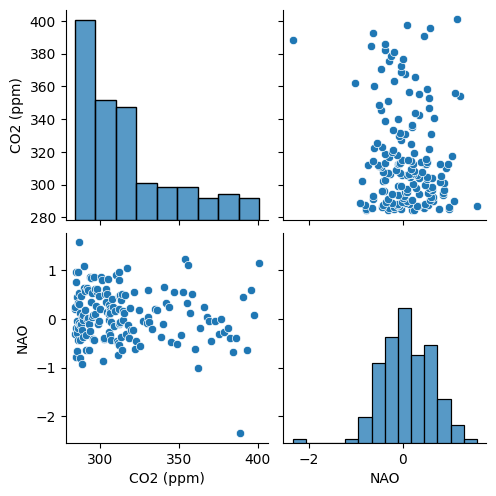

In [23]:
## Include code to answer 2.1, here:
file_path = "/content/drive/Shareddrives/GEOG-Paper_11_Envi_Data_Sci/L5/gmst_co2.xlsx"
df = pd.read_excel(file_path, sheet_name='cambridge')

#df.head()
#print(df.columns)
# Compute the correlation matrix between CO2 and the NAO index
correlation_matrix = df[['CO2 (ppm)', 'NAO']].corr()
# Alternatively, you can use a heatmap to visualize the correlation matrix
sns.pairplot(df[['CO2 (ppm)', 'NAO']])
plt.show()


*Include text giving a figure caption and discussing your answer for 2.1, here (1-2 sentences **each**)*:
Figure Caption
Pairplot showing the relationship between CO2 concentrations (ppm) and the NAO index, highlighting potential trends or associations between the two variables.

Is the model suitable for colinearlity?
Based on the correlation matrix and visualisation, assess the degree of collinearity. If the correlation is very high (close to 1 or -1), this could indicate potential multicollinearity, which may affect the regression model. If the correlation is relatively low or moderate (around 0), then both CO2 and NAO are suitable predictors for the regression model without significant collinearity concerns.



#### 2.2) _Fit a multilinear regression model_

 - Create the model: $Temp_{Cambridge} = a_1 \times CO_2 + a_2 \times NAO + b$ using `statsmodels` or `scikit-learn`.
 - Plot the original Cambridge temperature time series with the model's predicted values overlain.  
 - Evaluate the goodness-of-fit using metrics such as $R^2$ and mean squared error ($MSE$).  Provide a 1-2 sentence figure caption, referencing these goodness-of-fit measures.

                            OLS Regression Results                            
Dep. Variable:     Temperature (degC)   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     77.38
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           2.35e-24
Time:                        11:41:28   Log-Likelihood:                -116.41
No. Observations:                 166   AIC:                             238.8
Df Residuals:                     163   BIC:                             248.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4768      0.407     11.007      0.0

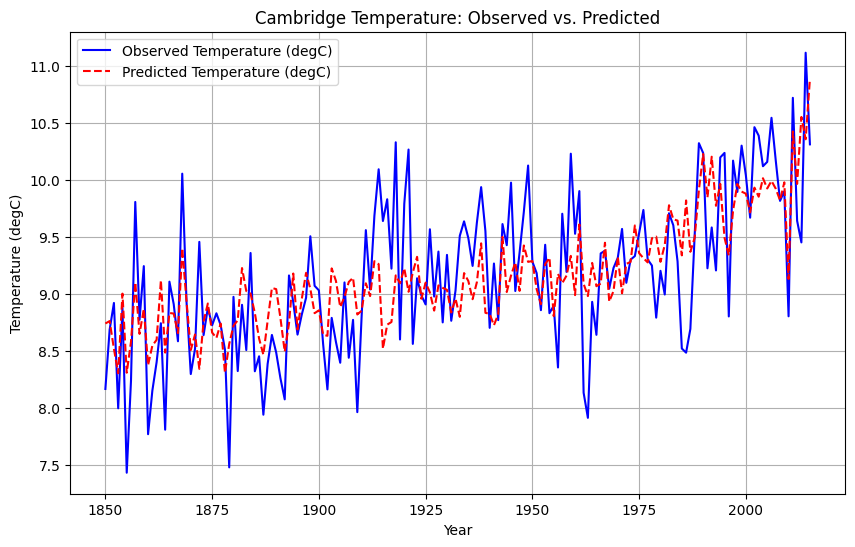

R-squared: 0.487
Mean Squared Error (MSE): 0.238


In [26]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
## Include code to answer 2.2, here:
X = df[['CO2 (ppm)', 'NAO']]  # Independent variables (CO2 and NAO)
y = df['Temperature (degC)']  # Dependent variable (Cambridge Temperature)

# Add a constant to the independent variables for the intercept (b)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary to check the model coefficients and R-squared value
print(model.summary())

# Get the predicted values from the model
y_pred = model.predict(X)

# Plot the original temperature data with the predicted values
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], y, label='Observed Temperature (degC)', color='blue')
plt.plot(df['Year'], y_pred, label='Predicted Temperature (degC)', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Temperature (degC)')
plt.title('Cambridge Temperature: Observed vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the goodness-of-fit
r2 = model.rsquared
mse = mean_squared_error(y, y_pred)

# Print R-squared and MSE
print(f'R-squared: {r2:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')


*Include a figure caption for 2.2, here (1-2 sentences)*:

Cambridge Temperatures:  Observed vs Predicted Explanation
"Observed and predicted Cambridge temperature time series from the multilinear regression model. The predicted values (red dashed line) closely track the observed temperatures (blue solid line), with an R-squared value of 0.487 and a Mean Squared Error (MSE) of 0.238, suggesting a moderate model fit."

Goodness of fit:
R-squared of 0.487 indicates that the model explains roughly 49% of the variance in the observed Cambridge temperatures, which suggests a moderate fit.
Mean Squared Error (MSE) of 0.238 quantifies the average squared difference between the observed and predicted temperatures. This relatively low value suggests that while the model has room for improvement, it is reasonably accurate in capturing the temperature trends.


#### 2.3 _Evaluate model residual structure_

- Plot a histogram of the model residuals and apply an appropriate statistical test to assess for normality (see L4).
- Plot the residuals against year to check for heteroscedasticity using visual inspection.  
- Based on your findings for both prior steps, comment (1-2 sentences) on whether a multilinear model is appropriate.

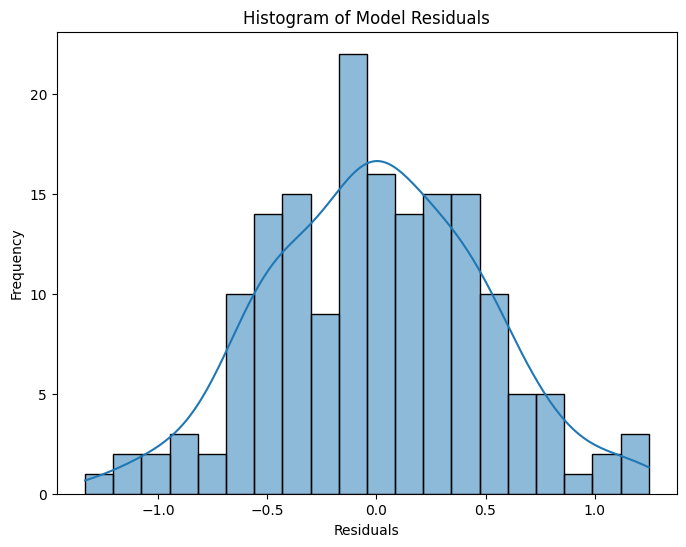

Shapiro-Wilk Test p-value: 0.9178204616438977


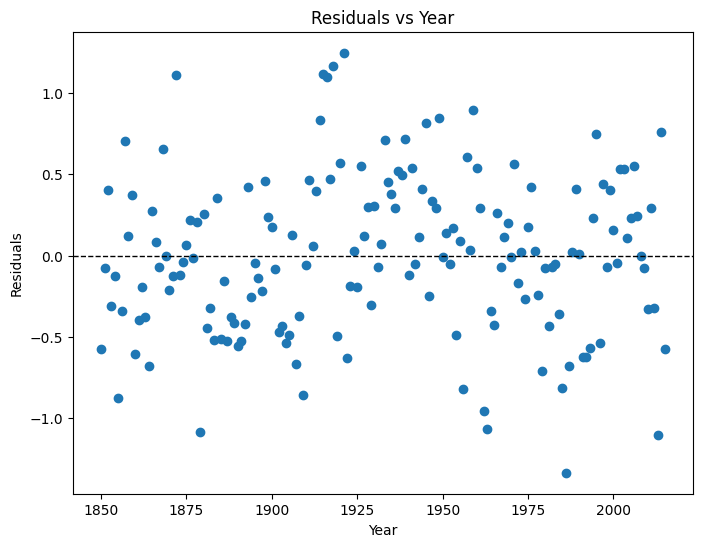

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

## Include code to answer 2.3, here:
# Calculate residuals
residuals = y - y_pred

# 1. Plot histogram of residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=20)
plt.title('Histogram of Model Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 2. Apply Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test p-value: {p_value}')

# 3. Plot residuals vs. year to check for heteroscedasticity
plt.figure(figsize=(8,6))
plt.scatter(df['Year'], residuals)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('Residuals vs Year')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.show()


*Include text discussing your answer for 2.3, here (1-2 sentences)*:

Since the p-value from the shapiro-Wilk test is 0.918, which is greater than 0.05, we fail to reject the null hypothesis that the residuals are normally distributed. This suggests that the residuals do not deviate significantly from a normal distribution, which is a positive indicator for the suitability of the multilinear regression model.

when plotting the residuals against the year, there is no discernible pattern or increasing spread over time. This absence of any clear structure suggests that the assumption of homoscedasticity (constant variance of errors) is not violated.

---


# Part 3: Nonlinear regression and prediction

The following questions touch on Demos 5 and 3 of Lecture 5.

---

For this Part, you're going to analyse monthly mean CO$_2$ measurements that have been made continuously at the Mauna Loa Observatory in Hawaii since ~1959 CE. The data appear to show two characteristic features: 1) a clear seasonal cycle in CO$_2$ concentrations$^1$ that is superimposed upon 2) an accelerating trend in CO$_2$ concentrations.

($^1$The CO$_2$ seasonal cycle is driven by Northern Hemisphere summer vegetation growth, which reduces atmospheric carbon dioxide, and winter vegetative decay, which increases it (i.e.,photosynthesis vs. respiration).)

First, let's load in the data and to see what we're dealing with (this code is provided for you -- just run the below-situated cell)!

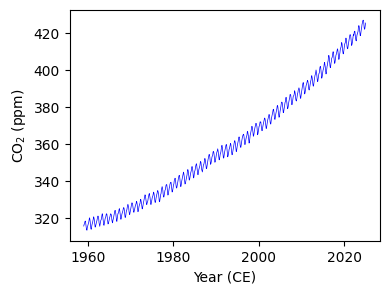

In [29]:
## load in the Mauna Loa CO2 data
filepath = '/content/drive/Shareddrives/GEOG-Paper_11_Envi_Data_Sci/L5/gmst_co2.xlsx'
co2 = pd.read_excel(filepath, sheet_name='co2_mauna_loa')

## rename columns for clarity (optional!)
co2.columns = ['year', 'month', 'time', 'co2', 'days', 'unc']

## plot it up
plt.figure(figsize=(4, 3))
plt.plot(co2['time'], co2['co2'], color='blue', linewidth=0.5)
plt.xlabel('Year (CE)')
plt.ylabel('CO$_2$ (ppm)')
plt.show()

So, we can see these two main features of the CO$_2$ data: a cyclical component (i.e., a  sine wave), situated atop an accelerating (near-quadratic) increase in concentration.  Thus we purport that an adequate mathematical description _might_ look something$^2$ like this:

$ CO_2(t) = at + bt^2 + Asin(2 \pi t + \phi) + c \tag{1} $

The independent variable, $t$, is an array of decimal years, $at$ is the increasing (linear) trend, $bt^2$ is the acceleration, $c$ is an intercept, and $Asin(2 \pi t + \phi)$ is the seasonal cycle component (with $A$ being the amplitude of the sine wave, and $\phi$, the "phase", shifting the sine wave horizontally).

($^2$*Aside*: this model could be similarly constructed using a power law with an added sinusoidal component!  E.g., $ CO_2(t) = at^b + Asin(2 \pi t + \phi) + c$.  But we'll stick with **Equation 1**, above, for fun.).

**You have 3 tasks to complete**:

---

_Observed monthly CO$_2$_:  

* _Citation_: Keeling, C.D., Bacastow, R.B., Bainbridge, A.E., Ekdahl, C.A., Jr., Guenther, P.R., Waterman, L.S. and Chin, J.F.S. (1976), Atmospheric carbon dioxide variations at Mauna Loa Observatory, Hawaii. Tellus, 28: 538-551. https://doi.org/10.1111/j.2153-3490.1976.tb00701.x

* _Data_: https://gml.noaa.gov/ccgg/trends/data.html

---

#### 3.1) _Fitting nonlinear equations_

- Use SciPy's `curve_fit` function to fit the provided CO$_2$ equation to the measured CO$_2$ time series.
- Compute the predicted CO$_2$ concentrations using `co2['time']` (i.e., $t$), based on the fitted model parameters.
- Display the final fitted model equation with the parameter estimates.
- Plot the original CO$_2$ time series, and overlay for comparison the predicted curve in a different color. Provide a 1-2 sentence figure caption summarising the figure/comparison.

---

**NOTE** To generate a sine wave use NumPy's `np.sin()`. Similarly, the number $π$ can be called with `np.pi`.

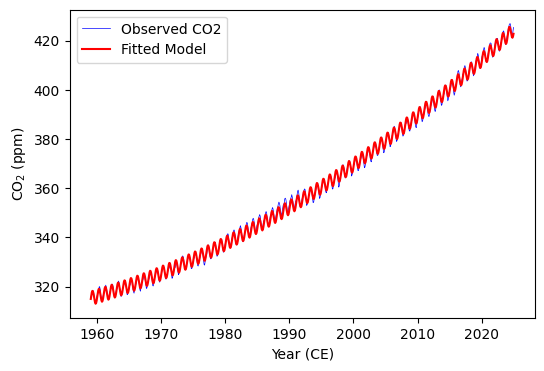

Fitted model: CO2(t) = -5.12e+01t + 1.33e-02t^2 + (2.83e+00)sin(2πt + -0.36) + 4.97e+04


In [32]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

## Include code to answer 3.1, here:
# Define the model function for fitting
def co2_model(t, a, b, A, phi, c):
    return a * t + b * t**2 + A * np.sin(2 * np.pi * t + phi) + c

# Fit the model to the data
params, covariance = curve_fit(co2_model, co2['time'], co2['co2'])

# Extract the fitted parameters
a, b, A, phi, c = params

# Compute the predicted CO2 concentrations
co2_pred = co2_model(co2['time'], a, b, A, phi, c)

# Plot the original CO2 time series and the fitted curve
plt.figure(figsize=(6, 4))
plt.plot(co2['time'], co2['co2'], label='Observed CO2', color='blue', linewidth=0.5)
plt.plot(co2['time'], co2_pred, label='Fitted Model', color='red', linewidth=1.5)
plt.xlabel('Year (CE)')
plt.ylabel('CO$_2$ (ppm)')
plt.legend()
plt.show()

# Display the fitted model equation with the parameter estimates
equation = f"CO2(t) = {a:.2e}t + {b:.2e}t^2 + ({A:.2e})sin(2πt + {phi:.2f}) + {c:.2e}"
print(f"Fitted model: {equation}")


*Include a figure caption for 3.1, here (1-2 sentences)*:
The plot shows the observed monthly CO2 concentrations from the Mauna Loa Observatory (blue) overlaid well with the predicted values from the fitted model (red). The model therefore, which accounts for both the linear trend and seasonal cycle, provides a reasonable fit to the observed data.

#### 3.1) _Cross-validation for seasonal CO$_2$ growth_

In this task, you'll apply cross-validation to assess your CO$_2$ seasonal growth model's predictive performance, by splitting the Mauna Loa CO$_2$ record into two parts: a **_training period_** (1959-2004) that will be used to fit the model, and a **_validation period_** (2005-2024) that will be used to evaluate how well the model predicts unseen data using goodness-of-fit metrics. Tasks:

- Split the dataset into a training period (1959-2004) and a validation period (2005-2024).
- Re-fit the CO$_2$ seasonal growth model (the same from 3.1) to the training period (1959-2004).
- Predict CO$_2$ values for both the training and validation periods using the re-fit model parameters.
- *Manually* calculate and and print the Coefficient of Determination ($R^2$) and the Root Mean Squared Error ($RMSE$) for _both_ the training and validation periods, using the formulas given in L5.
- Plot the original CO$_2$ time series, and overlay for comparison the training and validation CO$_2$ curves, each in different colours. Provide 2-4 sentences summarising the goodness-of-fit cross-validation metrics and your plotted results.

NOTE: In the lecture we illustrated that some built-in Python packages, like `scikit-learn` offer some off-the-shelf functions to do cross-validation.  But these are really not necessary if you're only performing a single training-validation split.  In this task, we want you to **manually** split the data and calculate the $R^2$ and $RMSE$, without relying on any external packages.

Training period R²: 0.997
Training period RMSE: 0.954
Validation period R²: 0.975
Validation period RMSE: 2.160


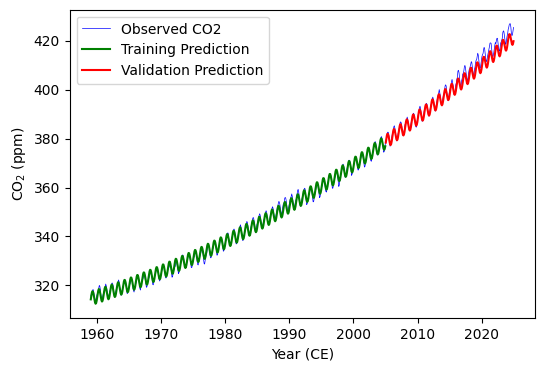

In [33]:
## Include code to answer 3.2, here:
# Split the dataset into training (1959-2004) and validation (2005-2024)
train_data = co2[co2['year'] <= 2004]
val_data = co2[co2['year'] >= 2005]

# Fit the model to the training data (1959-2004)
params_train, _ = curve_fit(co2_model, train_data['time'], train_data['co2'])
a_train, b_train, A_train, phi_train, c_train = params_train

# Predict CO2 for the training and validation periods
co2_train_pred = co2_model(train_data['time'], a_train, b_train, A_train, phi_train, c_train)
co2_val_pred = co2_model(val_data['time'], a_train, b_train, A_train, phi_train, c_train)

# Calculate the R-squared (R²) and Root Mean Squared Error (RMSE) for the training period
def calculate_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# R² and RMSE for training period
r2_train = calculate_r2(train_data['co2'], co2_train_pred)
rmse_train = calculate_rmse(train_data['co2'], co2_train_pred)

# R² and RMSE for validation period
r2_val = calculate_r2(val_data['co2'], co2_val_pred)
rmse_val = calculate_rmse(val_data['co2'], co2_val_pred)

# Print the R² and RMSE results
print(f"Training period R²: {r2_train:.3f}")
print(f"Training period RMSE: {rmse_train:.3f}")
print(f"Validation period R²: {r2_val:.3f}")
print(f"Validation period RMSE: {rmse_val:.3f}")

# Plot the observed and predicted CO2 values
plt.figure(figsize=(6, 4))
plt.plot(co2['time'], co2['co2'], label='Observed CO2', color='blue', linewidth=0.5)
plt.plot(train_data['time'], co2_train_pred, label='Training Prediction', color='green', linewidth=1.5)
plt.plot(val_data['time'], co2_val_pred, label='Validation Prediction', color='red', linewidth=1.5)
plt.xlabel('Year (CE)')
plt.ylabel('CO$_2$ (ppm)')
plt.legend()
plt.show()





*Include text discussing your answer for 3.2, here (2-4 sentences)*:
The plot compares the observed monthly CO2 concentrations from the Mauna Loa Observatory (blue) with the predicted values from the CO2 seasonal growth model for both the training period (green) and the validation period (red). The model fits the training data with a high R² of 0.997 and low RMSE of 0.954, indicating excellent predictive performance. Although the model performs well on the validation period with an R² of 0.975 and RMSE of 2.160, the RMSE is slightly higher, reflecting a slight increase in prediction error for unseen data.

Training period R²: 0.997: The model fits the training data very well, explaining 99.7% of the variance in the CO2 concentrations.
Training period RMSE: 0.954: The model’s predictions for the training period have an average error of about 0.954 ppm.
Validation period R²: 0.975: The model explains 97.5% of the variance in the CO2 data during the validation period, demonstrating strong performance on unseen data.
Validation period RMSE: 2.160: The model’s prediction error for the validation period is slightly higher at 2.160 ppm, indicating that the model could be further refined to reduce this discrepancy.



#### 3.3) Prediction and interpretation

- The next [Transit of Mercury ](https://listverse.com/2024/05/10/10-astonishing-cosmic-events-expected-in-the-next-50-years/) is set to occur on November 13th, 2032.  Using your predictive model from 3.1, estimate the CO$_2$ concentration on November 13th, 2032. Based on the $RMSE$ you calculated in 3.2, provide the predicted range of CO₂ (i.e., prediction ± RMSE).
- Reflect on whether this range of uncertainty is realistic. Do you believe it fully captures the uncertainty in predicting future CO$_2$? Similarly, consider the model's underlying assumptions (e.g., constant growth/acceleration rates, consistent seasonal cycles, etc) and discuss whether they'll hold into the future. Please postulate in 4-8 sentences.

In [35]:
## Include code to answer 3.3, here:
# Model parameters from fitting in 3.1 (substitute with the actual fitted values)
a = -51.2
b = 0.0133
A = 2.83
phi = -0.36
c = 49700

# Define the time for November 13th, 2032
# t is the decimal year, calculate t for November 13, 2032
year_2032 = 2032 + (13 / 365)  # Approximate decimal year for November 13th, 2032

# Predict the CO2 concentration for November 13th, 2032
co2_pred_2032 = a * year_2032 + b * year_2032**2 + A * np.sin(2 * np.pi * year_2032 + phi) + c

# RMSE from the previous validation (substitute the actual RMSE value)
rmse = 2.160

# Calculate the predicted range (± RMSE)
lower_bound = co2_pred_2032 - rmse
upper_bound = co2_pred_2032 + rmse

# Print the predicted value and range
print(f"Predicted CO₂ concentration on November 13th, 2032: {co2_pred_2032:.3f} ppm")
print(f"Prediction range: {lower_bound:.3f} ppm to {upper_bound:.3f} ppm")

Predicted CO₂ concentration on November 13th, 2032: 577.336 ppm
Prediction range: 575.176 ppm to 579.496 ppm


*Include text discussing your answer for 3.3, here (4-8 sentences)*:

The predicted CO₂ concentration for November 13th, 2032, is 577.336 ppm, with a prediction range of 575.176 ppm to 579.496 ppm. This range is based on the root mean squared error (RMSE) from the validation period, which provides an estimate of the model’s residual variability. While the model's prediction gives us a point estimate of CO₂ levels, the uncertainty captured by the RMSE indicates the potential deviation from the predicted value. The range of ±2.160 ppm reflects a plausible level of uncertainty, but it may not fully account for all factors influencing future CO₂ levels, such as changes in human activity, technological advancements, and natural climate feedbacks. Thus, while the prediction is useful for providing a rough estimate, it should be treated with caution, as the future trajectory of CO₂ could diverge from the model’s assumptions over time.
---

# End of Problem Set 4

---

*HINT for Part 1.1*:

```
# you shouldn't need to import any extra packages beyond XArray to do this; here's a code template ...

## grab the appropriate netcdf data
filepath = '/path_to_the_datafile/the_datafile.nc'
ds = xr.open_dataset(filepath)
temp = ds['temperature']  # adjust for the actual variable name in the netcdf file

## calculate annual means then subset (index) your data from MINYEAR to MAXYEAR
temp_annual = temp.groupby('time.year').mean().sel(year=slice(MINYEAR, MAXYEAR))
```

---